IMPORT THE NECCESSARY LIBRARIES

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import joblib


SINCE WE HAVE NO DATASET, A SYTHENTIC DATASET WOULD BE CREATED

In [28]:
# Set a seed for reproducibility
np.random.seed(42)

# Parameters
num_samples = 10000
start_date = datetime(2020, 1, 1)

# To generate timestamps
timestamps = [start_date + timedelta(minutes=15 * i) for i in range(num_samples)]

# Simulate sensor readings, indicating the mean and standard dev
temperature = np.random.normal(70, 5, num_samples)
pressure = np.random.normal(100, 10, num_samples)
vibration = np.random.normal(0.5, 0.1, num_samples)

# Generating operating conditions (e.g., normal, stressed)
operating_conditions = np.random.choice(['normal', 'stressed'], num_samples, p = [0.8, 0.2])

# Simulate historical maintenance events
# Randomly mark some timestamps as having maintenance
historical_maintenance = np.zeros(num_samples)
maintenance_indices = np.random.choice(num_samples, size=int(num_samples * 0.1), replace=False)  # 10% maintenance
historical_maintenance[maintenance_indices] = 1

# Simulate binary outcome (1= Failure, 0= No Failure)
failure_prob = np.random.uniform(0, 1, num_samples)
failures = (failure_prob < 0.05).astype(int)    # 5% of failure



# Create the DataFrame after adding the new column
data = pd.DataFrame({
    'timestamp': timestamps,
    'temperature': temperature,
    'pressure': pressure,
    'vibration': vibration,
    'operating_condition': operating_conditions,
    'historical_maintenance': historical_maintenance.astype(int),  # Convert to int for binary values
    'failure': failures
})

# Display first few rows of the modified data
print(data.head())

            timestamp  temperature    pressure  vibration operating_condition  \
0 2020-01-01 00:00:00    72.483571   93.215053   0.534829            stressed   
1 2020-01-01 00:15:00    69.308678   96.945005   0.528332            stressed   
2 2020-01-01 00:30:00    73.238443   94.026189   0.406348              normal   
3 2020-01-01 00:45:00    77.615149  101.104180   0.557958              normal   
4 2020-01-01 01:00:00    68.829233  111.971785   0.350992              normal   

   historical_maintenance  failure  
0                       0        0  
1                       0        0  
2                       1        0  
3                       0        0  
4                       0        0  


CREATE A COLUMN FOR THE FAILURE WITHIN 24HRS TIMEFRAME

In [29]:
# Add the 'failure_within_timeframe' column to the existing data DataFrame
data['failure_within_timeframe'] = 0  

# To check if a failure occurs within the specified time window (e.g., 24 hours)
timeframe = 24 
for i in range(len(data)):
    current_timestamp = data.loc[i, 'timestamp']

    # Look ahead in the dataframe to find if a failure occurs within the timeframe
    future_failures = data[(data['timestamp'] > current_timestamp) & 
                            (data['timestamp'] <= current_timestamp + timedelta(hours=timeframe))]
    if future_failures['failure'].sum() > 0:
        data.loc[i, 'failure_within_timeframe'] = 1  # Mark as failure within the timeframe

In [30]:
data.head(5)

,timestamp,temperature,pressure,vibration,operating_condition,historical_maintenance,failure,failure_within_timeframe
0,2020-01-01 00:00:00,72.483571,93.215053,0.534829,stressed,0,0,1
1,2020-01-01 00:15:00,69.308678,96.945005,0.528332,stressed,0,0,1
2,2020-01-01 00:30:00,73.238443,94.026189,0.406348,normal,1,0,1
3,2020-01-01 00:45:00,77.615149,101.104180,0.557958,normal,0,0,1
4,2020-01-01 01:00:00,68.829233,111.971785,0.350992,normal,0,0,1


SAVE THE DATA TO A CSV FILE

In [31]:
# Save the data to a CSV file
data.to_csv('synthetic_machine_data_with_24h_failures.csv', index=False)

In [32]:
data.isnull().sum()

timestamp                   0
temperature                 0
pressure                    0
vibration                   0
operating_condition         0
historical_maintenance      0
failure                     0
failure_within_timeframe    0
dtype: int64

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   timestamp                 10000 non-null  datetime64[ns]
 1   temperature               10000 non-null  float64       
 2   pressure                  10000 non-null  float64       
 3   vibration                 10000 non-null  float64       
 4   operating_condition       10000 non-null  object        
 5   historical_maintenance    10000 non-null  int32         
 6   failure                   10000 non-null  int32         
 7   failure_within_timeframe  10000 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int32(2), int64(1), object(1)
memory usage: 547.0+ KB


CHANGE THE CATEGORICAL FEATURES TO NUMERICAL VALUE

In [34]:
le = LabelEncoder()
data['operating_condition'] = le.fit_transform(data['operating_condition'])
data.head(3)

,timestamp,temperature,pressure,vibration,operating_condition,historical_maintenance,failure,failure_within_timeframe
0,2020-01-01 00:00:00,72.483571,93.215053,0.534829,1,0,0,1
1,2020-01-01 00:15:00,69.308678,96.945005,0.528332,1,0,0,1
2,2020-01-01 00:30:00,73.238443,94.026189,0.406348,0,1,0,1


DATA STANDARDIZATION

In [35]:
scaler = StandardScaler()
features_to_standardize = ['temperature', 'pressure', 'vibration']

data[features_to_standardize] = scaler.fit_transform(data[features_to_standardize])
data.head(2)

,timestamp,temperature,pressure,vibration,operating_condition,historical_maintenance,failure,failure_within_timeframe
0,2020-01-01 00:00:00,0.497154,-0.691365,0.363890,1,0,0,1
1,2020-01-01 00:15:00,-0.135665,-0.318727,0.298362,1,0,0,1


FEATURES SELECTION FOR THE PREDICTION OF FAILURE

In [36]:
X = data.drop(columns=['timestamp', 'failure', 'failure_within_timeframe'], axis=1)
y = data['failure']

TRAIN TEST SPLIT

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

MODEL DEVELOPMENT USING RANDOM FOREST CLASSIFIER

In [38]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

Accuracy: 0.96
Precision: 0.00
Recall: 0.00
AUC-ROC: 0.50


c:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


FEATURES SELECTION USING FOR THE FAILURE WITHIN 24 HRS TIMEFRAME

In [39]:
XX = data.drop(columns=['timestamp', 'failure', 'failure_within_timeframe'], axis=1)
yy = data['failure_within_timeframe']

In [40]:
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=0.2, random_state=42)

MODEL DEVELOPMENT FOR THR 24 HOURS TIMEFRAME AND PREDICTION

In [44]:
model_1 = RandomForestClassifier()
model_1.fit(XX_train, yy_train)

# Model Evaluation
yy_pred = model.predict(XX_test)
accuracy = accuracy_score(yy_test, yy_pred)
precision = precision_score(yy_test, yy_pred)
recall = recall_score(yy_test, yy_pred)
roc_auc = roc_auc_score(yy_test, yy_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

Accuracy: 0.99
Precision: 0.99
Recall: 1.00
AUC-ROC: 0.50


TO SAVE THE MODEL

In [42]:
import joblib
joblib.dump(model, 'machine_failure_model.pkl')

['machine_failure_model.pkl']

CONFUSION MATRIX AND FAETURE IMPORTANCE FOR THE FAILURE

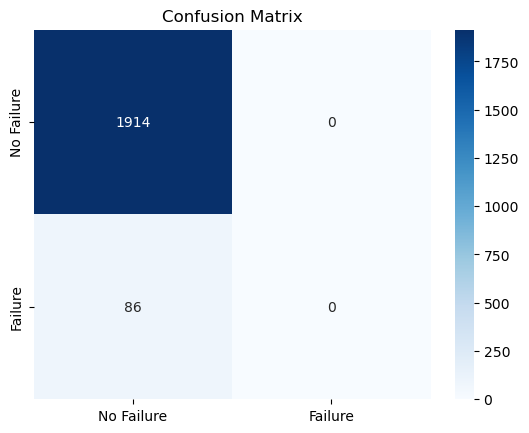

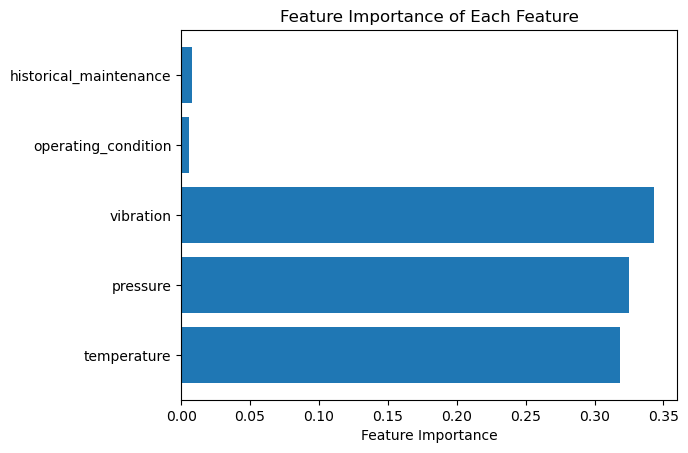

In [43]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
plt.title("Confusion Matrix")
plt.show()

# Feature importance
feature_importance = model.feature_importances_
plt.barh(X.columns, feature_importance)
plt.xlabel("Feature Importance")
plt.title("Feature Importance of Each Feature")
plt.show()

CONFUSION MATRIX AND FEATURE IMPORTANCE FOR FAILURE WITHIN TIMEFRAME

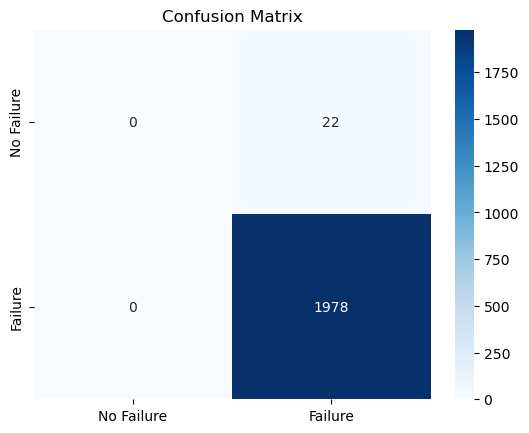

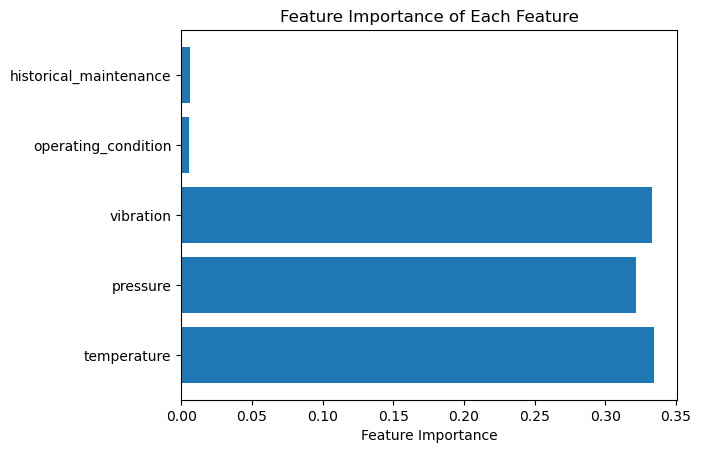

In [45]:
# Confusion matrix
cm = confusion_matrix(yy_test, yy_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
plt.title("Confusion Matrix")
plt.show()

# Feature importance
feature_importance = model_1.feature_importances_
plt.barh(XX.columns, feature_importance)
plt.xlabel("Feature Importance")
plt.title("Feature Importance of Each Feature")
plt.show()

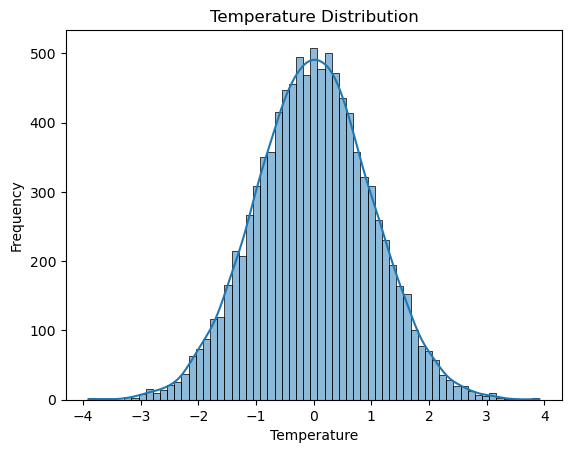

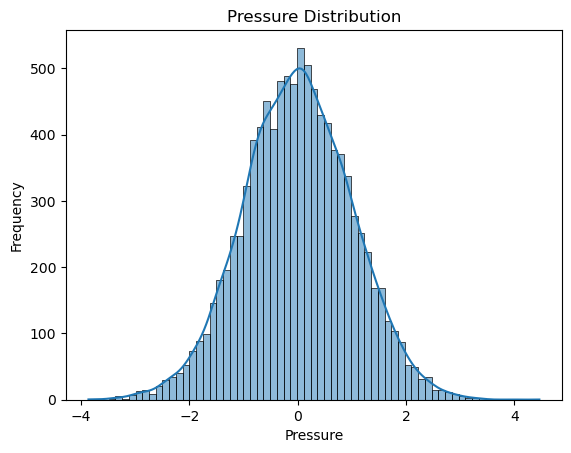

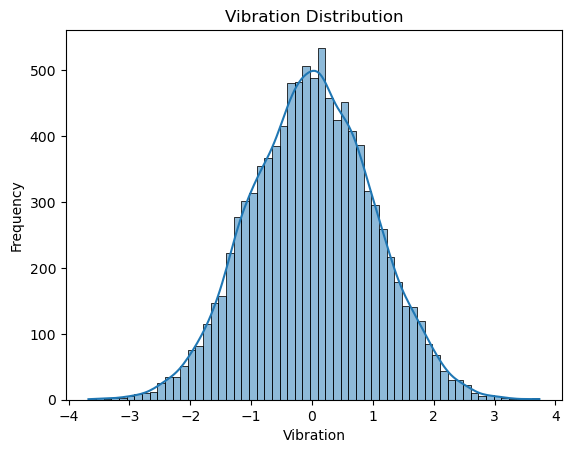

In [46]:
# Visualize distribution of key features like temperature, pressure, and vibration
sns.histplot(data['temperature'], kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data['pressure'], kde=True)
plt.title('Pressure Distribution')
plt.xlabel('Pressure')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data['vibration'], kde=True)
plt.title('Vibration Distribution')
plt.xlabel('Vibration')
plt.ylabel('Frequency')
plt.show()


SAMPLE PREDICTION FOR THE FAILURE

In [47]:
# Get a sample of 5 rows for prediction
sample_data = X_test.head(5)
sample_predictions = model.predict_proba(sample_data)

# Show predictions (probabilities for each class)
for i, sample in enumerate(sample_data.index):
    print(f"Sample {sample}:")
    print(f"Predicted probabilities: Failure = {sample_predictions[i][1]:.4f}, No Failure = {sample_predictions[i][0]:.4f}")


Sample 6252:
Predicted probabilities: Failure = 1.0000, No Failure = 0.0000
Sample 4684:
Predicted probabilities: Failure = 1.0000, No Failure = 0.0000
Sample 1731:
Predicted probabilities: Failure = 0.9900, No Failure = 0.0100
Sample 4742:
Predicted probabilities: Failure = 1.0000, No Failure = 0.0000
Sample 4521:
Predicted probabilities: Failure = 0.9900, No Failure = 0.0100


SAMPLE PREDICTION FOR FAILURE WITHIN TIMEFRAME

In [50]:
# Get a sample of 5 rows for prediction
sample_data = XX_test.head(5)
sample_predictions = model_1.predict_proba(sample_data)

# Show predictions (probabilities for each class)
for i, sample in enumerate(sample_data.index):
    print(f"Sample {sample}:")
    print(f"Predicted probabilities: Failure = {sample_predictions[i][1]:.4f}, No Failure = {sample_predictions[i][0]:.4f}")


Sample 6252:
Predicted probabilities: Failure = 0.9900, No Failure = 0.0100
Sample 4684:
Predicted probabilities: Failure = 1.0000, No Failure = 0.0000
Sample 1731:
Predicted probabilities: Failure = 1.0000, No Failure = 0.0000
Sample 4742:
Predicted probabilities: Failure = 1.0000, No Failure = 0.0000
Sample 4521:
Predicted probabilities: Failure = 0.9900, No Failure = 0.0100
